<a href="https://colab.research.google.com/github/lisa-sophia/MPC-satellite-formation-controller/blob/master/cifar10_image_classifciation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import tensorflow as tf

# If there are multiple GPUs and we only want to use one/some, set the number in the visible device list.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 

### **Loading the dataset**
I am using the CIFAR10 dataset. This is a collection of small images in 10 classes such as cars, cats, birds, etc. More information here: https://www.cs.toronto.edu/~kriz/cifar.html. 


In [4]:
import numpy as np
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


##### **Plotting some images**
This plots a random selection of images from each class. Rerun the cell to see a different selection.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import sys
module_path = os.path.abspath('/content/drive/MyDrive/Colab Notebooks')
if module_path not in sys.path:
    sys.path.append(module_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


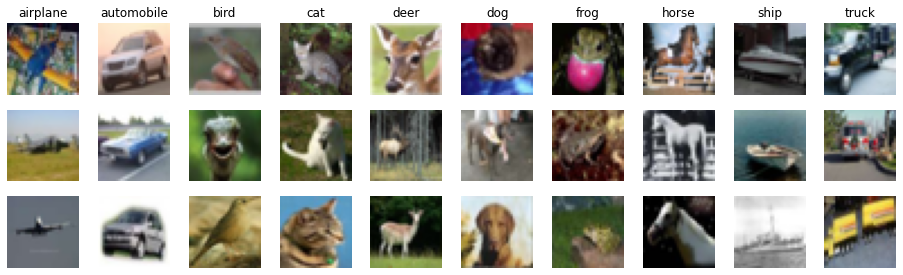

In [6]:
from Custom import PlotRandomFromEachClass

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
PlotRandomFromEachClass(X_train, y_train, 3, labels=cifar_labels)

##### **Preparing the dataset**
Normalizing the images to [0,1] and transforming the class indices to one-hot encoded vectors.

In [7]:
from tensorflow.keras.utils import to_categorical

# Transform label indices to one-hot encoded vectors
y_train_c = to_categorical(y_train, num_classes=10)
y_test_c  = to_categorical(y_test , num_classes=10)

# Normalization of pixel values (to [0-1] range)
X_train = X_train.astype('float32') / 255
X_test  = X_test.astype('float32')  / 255

### **1. Fully connected classifier**
Start by creating a fully connected classifier using the ```Dense``` layer. The first layer flattens the image features to a single vector. Then follow the dense layers.

In [30]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

x_in = Input(shape=X_train.shape[1:])
x = Flatten()(x_in)

x = Dense(100, activation='relu')(x) 
x = Dense(100, activation='tanh')(x)
x = Dense(100, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=x_in, outputs=x)

# Building the model using Stochastic Gradient Descent with Nesterov momentum. Using accuracy as the metric.
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(100)

Model: "model_5"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_6 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
flatten_5 (Flatten)                          (None, 3072)                            0              
____________________________________________________________________________________________________
dense_8 (Dense)                              (None, 100)                             307300         
____________________________________________________________________________________________________
dense_9 (Dense)                              (None, 100)                             10100          
__________________________________________________________________________

##### **Training the model**
Training the model using 15 epochs, batch size 32, and 20% validation data. 

In [9]:
history = model.fit(X_train,y_train_c, epochs=15, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8444 - accuracy: 0.3286 - val_loss: 1.7365 - val_accuracy: 0.3741
Epoch 2/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6767 - accuracy: 0.3939 - val_loss: 1.6662 - val_accuracy: 0.4046
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6100 - accuracy: 0.4190 - val_loss: 1.6296 - val_accuracy: 0.4135
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5656 - accuracy: 0.4367 - val_loss: 1.6117 - val_accuracy: 0.4225
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5387 - accuracy: 0.4476 - val_loss: 1.5540 - val_accuracy: 0.4433
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5078 - accuracy: 0.4603 - val_loss: 1.5592 - val_accuracy: 0.4414
Epoch 7/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4947 - accuracy: 0.4631 - val_loss: 1.5675 - val_accuracy:

##### **Evaluating the model**
Using ```model.evaluate``` to get the loss and metric scores on the test data. In Custom.py a neat way to plot the results (confusion matrix and training progress) is defined. That function is called "PlotModelEval".

In [10]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 1.517
Test accuracy = 0.465


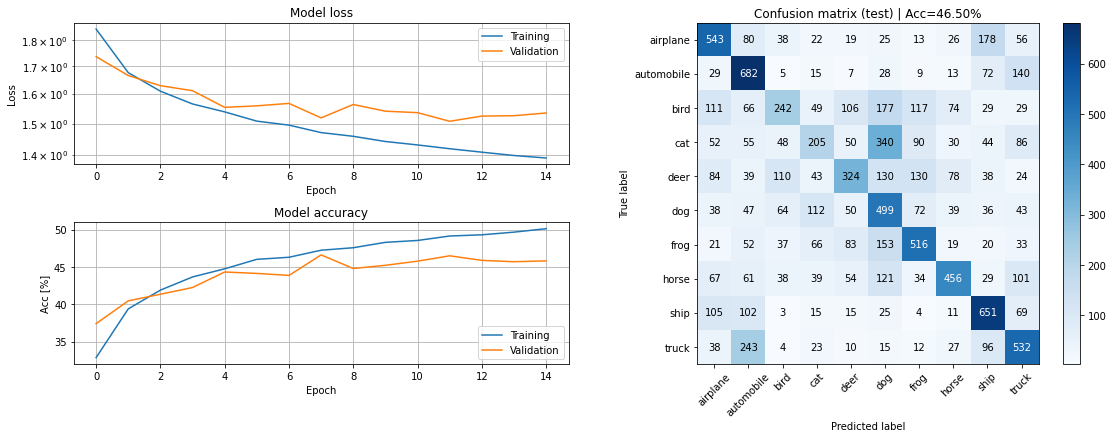

In [11]:
from Custom import PlotModelEval

# Custom function for evaluating the model and plotting training history
PlotModelEval(model, history, X_test, y_test, cifar_labels)

### **2. CNN classifier**
The fully connected classifier is not particularly good, instead use a network architecture that is more suited for this problem: a convolutional neural network (CNN). For this the layers ```Conv2D``` and ```MaxPooling2D``` are used, documentation can be found here: 

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D 

https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D.

##### **Creating the CNN model**

Creating blocks of layers of the form **[convolution - activation - pooling]**, and then stacking several of these block to create the full convolution stack. Then a dense fully connected layer to create the output classes.

In [12]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

x_in = Input(shape=X_train.shape[1:])
print(x_in.shape)

# Block 1
x = Conv2D(filters=100, kernel_size=3 ,activation='relu', input_shape=x_in.shape[1:])(x_in)
x = MaxPooling2D()(x)

# Block 2
print(x.shape)
x = Conv2D(filters=200, kernel_size=3 ,activation='relu')(x)
x = MaxPooling2D()(x)

# # Block 3
# print(x.shape)
# x = Conv2D(filters=300, kernel_size=3 ,activation='relu')(x)
# x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=x_in, outputs=x)

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

(None, 32, 32, 3)
(None, 15, 15, 100)
Model: "model_1"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_2 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d (Conv2D)                              (None, 30, 30, 100)                     2800           
____________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)                 (None, 15, 15, 100)                     0              
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                            (None, 13, 13, 200)                     180200         
____________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


##### **Training the CNN**

In [13]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 235s 188ms/step - loss: 1.5556 - accuracy: 0.4447 - val_loss: 1.2344 - val_accuracy: 0.5705
Epoch 2/15
1250/1250 [==============================] - 235s 188ms/step - loss: 1.1341 - accuracy: 0.6046 - val_loss: 1.0741 - val_accuracy: 0.6302
Epoch 3/15
1250/1250 [==============================] - 233s 186ms/step - loss: 0.9749 - accuracy: 0.6636 - val_loss: 0.9823 - val_accuracy: 0.6638
Epoch 4/15
1250/1250 [==============================] - 233s 186ms/step - loss: 0.8628 - accuracy: 0.7039 - val_loss: 0.9312 - val_accuracy: 0.6812
Epoch 5/15
1250/1250 [==============================] - 233s 186ms/step - loss: 0.7790 - accuracy: 0.7294 - val_loss: 0.9015 - val_accuracy: 0.6951
Epoch 6/15
1250/1250 [==============================] - 231s 185ms/step - loss: 0.7004 - accuracy: 0.7597 - val_loss: 0.9447 - val_accuracy: 0.6835
Epoch 7/15
1250/1250 [==============================] - 232s 186ms/step - loss: 0.6358 - accuracy: 0.7804 - val_

##### **Evaluating the CNN**

In [14]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 1.416
Test accuracy = 0.681


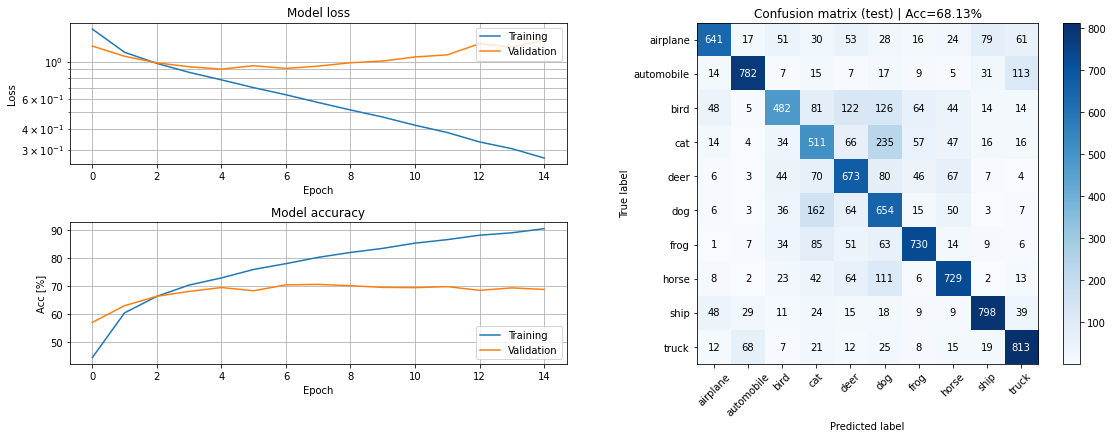

In [15]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

### **3. Regularization**

#### **3.1 Dropout**
The CNN model seems to overfit the training data. One way to prevent this is to add ```Dropout``` layers to the model, that randomly "drops" hidden nodes each training-iteration by setting their output to zero. Thus the model cannot rely on a small set of very good hidden features, but must instead learn to use different sets of hidden features each time. Add the dropout layers after the pooling layers in the convolution part of the model, or after activations in the fully connected part of the model.

In [16]:
from tensorflow.keras.layers import Dropout

x_in = Input(shape=X_train.shape[1:])

# Block 1
x = Conv2D(filters=100, kernel_size=3 ,activation='relu', input_shape=x_in.shape[1:])(x_in)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

# Block 2
print(x.shape)
x = Conv2D(filters=200, kernel_size=3 ,activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

# Fully connected part
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=x_in, outputs=x)

# Compile model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

(None, 15, 15, 100)
Model: "model_2"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_3 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                            (None, 30, 30, 100)                     2800           
____________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)               (None, 15, 15, 100)                     0              
____________________________________________________________________________________________________
dropout (Dropout)                            (None, 15, 15, 100)                     0              
______________________________________________________

In [17]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 265s 212ms/step - loss: 1.5946 - accuracy: 0.4290 - val_loss: 1.2917 - val_accuracy: 0.5569
Epoch 2/15
1250/1250 [==============================] - 247s 197ms/step - loss: 1.1968 - accuracy: 0.5808 - val_loss: 1.1006 - val_accuracy: 0.6214
Epoch 3/15
1250/1250 [==============================] - 244s 195ms/step - loss: 1.0575 - accuracy: 0.6319 - val_loss: 1.0216 - val_accuracy: 0.6463
Epoch 4/15
1250/1250 [==============================] - 244s 195ms/step - loss: 0.9679 - accuracy: 0.6639 - val_loss: 0.9382 - val_accuracy: 0.6829
Epoch 5/15
1250/1250 [==============================] - 244s 195ms/step - loss: 0.9040 - accuracy: 0.6873 - val_loss: 0.9518 - val_accuracy: 0.6732
Epoch 6/15
1250/1250 [==============================] - 243s 195ms/step - loss: 0.8547 - accuracy: 0.7063 - val_loss: 0.9269 - val_accuracy: 0.6846
Epoch 7/15
1250/1250 [==============================] - 243s 194ms/step - loss: 0.8055 - accuracy: 0.7201 - val_

In [18]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 0.880
Test accuracy = 0.711


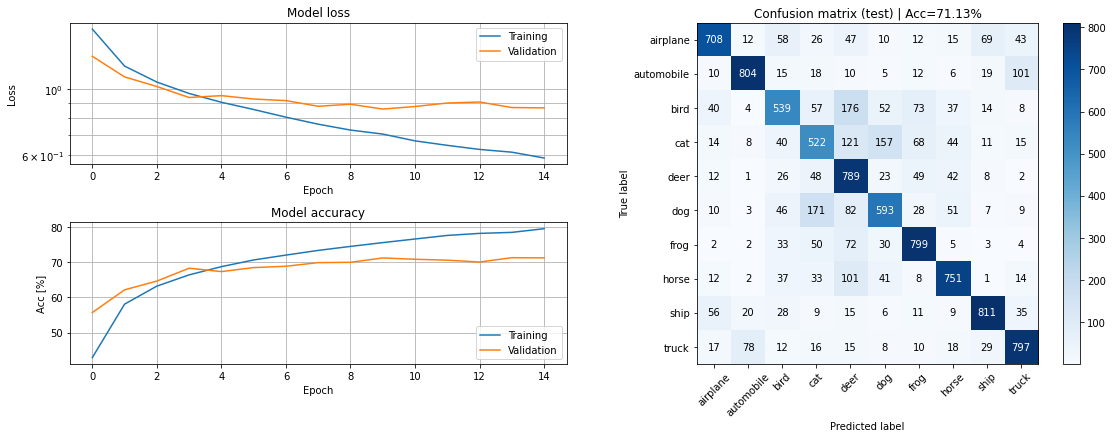

In [19]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

#### **3.2 Batch normalization**
Trying to add a batch normalization layer (normalizes the data in each batch to have a specific mean and standard deviation, which is learned during training): https://keras.io/api/layers/normalization_layers/batch_normalization/. This can help the optimization converge faster which means getting higher performance in fewer epochs. The normalization is done separatly for each feature, i.e. the statistics are calculated across the batch dimension of the input data. The equation is 
$$ \gamma *  \frac{batch - mean(batch)} { \sqrt{var(batch) + \epsilon}} + \beta $$.

This means that we begin by scaling and shifting the data to have a mean of 0 and standard deviation of 1. The parameters $\gamma$ and $\beta$ that are learnt (using gradiend descent) decide the width and center of the final distribution. $\epsilon$ is a small constant value that prevents the denominator from being zero.

In addition to learning the parameters $\gamma$ and $\beta$ by gradient decent just like the weights, Batch Normalization also keeps track of the running average of minibatch statistics $\mu$ and $\sigma$. These averages are used to normalize the test data. We can tune the rate at which the running averages are updated with the *momentum* parameter of the BatchNormalization layer. A large momentum means that the statistics converge more slowly and therefore requires more updates before it represents the data. A low momentum, on the other hand, adapts to the data more quickly but might lead to unstable behaviour if the latest minibatches are not representative of the whole dataset. 

The batch normalization layer should be added after the hidden layer linear transformation, but before the nonlinear activation. This means that we cannot specify the activation funciton in the ```Conv2D``` or ```Dense``` if we want to batch-normalize the output. We therefore need to use the ```Activation``` layer to add a separate activation to the network stack after batch normalization. For example, the convolution block will now look like **[conv - batchnorm - activation - pooling]**.

In [20]:
from tensorflow.keras.layers import BatchNormalization, Activation

x_in = Input(shape=X_train.shape[1:])

# Block 1
x = Conv2D(filters=100, kernel_size=3 ,activation=None, input_shape=x_in.shape[1:])(x_in)
x = BatchNormalization(epsilon=0.001, momentum=0.75)(x)
x = Activation(activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

# Block 2
print(x.shape)
x = Conv2D(filters=200, kernel_size=3 ,activation=None)(x)
x = BatchNormalization(epsilon=0.001, momentum=0.75)(x)
x = Activation(activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

# Fully connected part
x = Flatten()(x)
x = Dense(10, activation=None)(x)
x = BatchNormalization(epsilon=0.001, momentum=0.75)(x)
x = Activation(activation='softmax')(x)

model = Model(inputs=x_in, outputs=x)

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)

(None, 15, 15, 100)
Model: "model_3"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_4 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                            (None, 30, 30, 100)                     2800           
____________________________________________________________________________________________________
batch_normalization (BatchNormalization)     (None, 30, 30, 100)                     400            
____________________________________________________________________________________________________
activation (Activation)                      (None, 30, 30, 100)                     0              
______________________________________________________

In [22]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 309s 247ms/step - loss: 0.8485 - accuracy: 0.7052 - val_loss: 0.8588 - val_accuracy: 0.7089
Epoch 2/15
1250/1250 [==============================] - 307s 246ms/step - loss: 0.8116 - accuracy: 0.7175 - val_loss: 0.8252 - val_accuracy: 0.7176
Epoch 3/15
1250/1250 [==============================] - 305s 244ms/step - loss: 0.7719 - accuracy: 0.7331 - val_loss: 0.7936 - val_accuracy: 0.7268
Epoch 4/15
1250/1250 [==============================] - 305s 244ms/step - loss: 0.7397 - accuracy: 0.7442 - val_loss: 0.7787 - val_accuracy: 0.7314
Epoch 5/15
1250/1250 [==============================] - 305s 244ms/step - loss: 0.7156 - accuracy: 0.7502 - val_loss: 0.8243 - val_accuracy: 0.7192
Epoch 6/15
1250/1250 [==============================] - 305s 244ms/step - loss: 0.6830 - accuracy: 0.7609 - val_loss: 0.8083 - val_accuracy: 0.7265
Epoch 7/15
1250/1250 [==============================] - 303s 242ms/step - loss: 0.6552 - accuracy: 0.7714 - val_

In [23]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 0.728
Test accuracy = 0.758


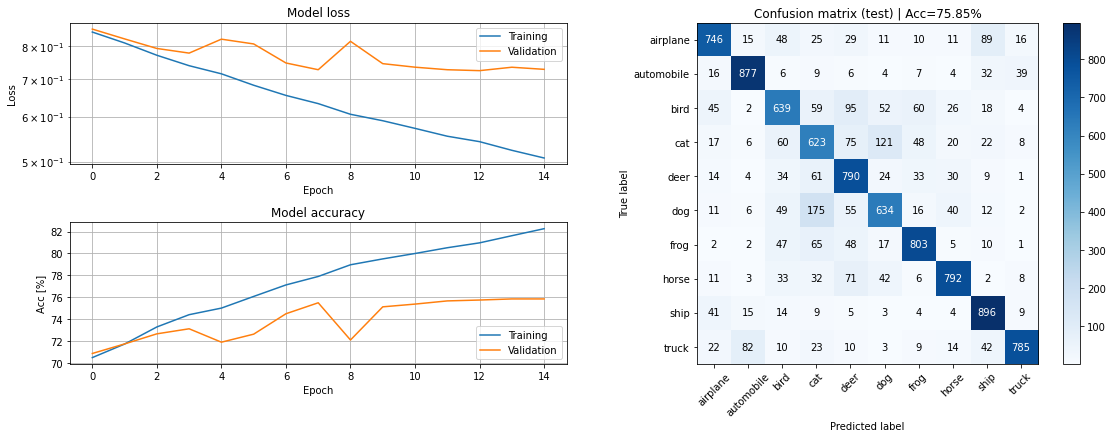

In [24]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

### **Optimizing the model**
Playing around a bit with the number of blocks, the layers, the activation functions, etc., to try to improve the performance.

(None, 12, 12, 100)
Model: "model_4"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_5 (InputLayer)                         [(None, 32, 32, 3)]                     0              
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                            (None, 25, 25, 100)                     19300          
____________________________________________________________________________________________________
batch_normalization_3 (BatchNormalization)   (None, 25, 25, 100)                     400            
____________________________________________________________________________________________________
activation_3 (Activation)                    (None, 25, 25, 100)                     0              
______________________________________________________

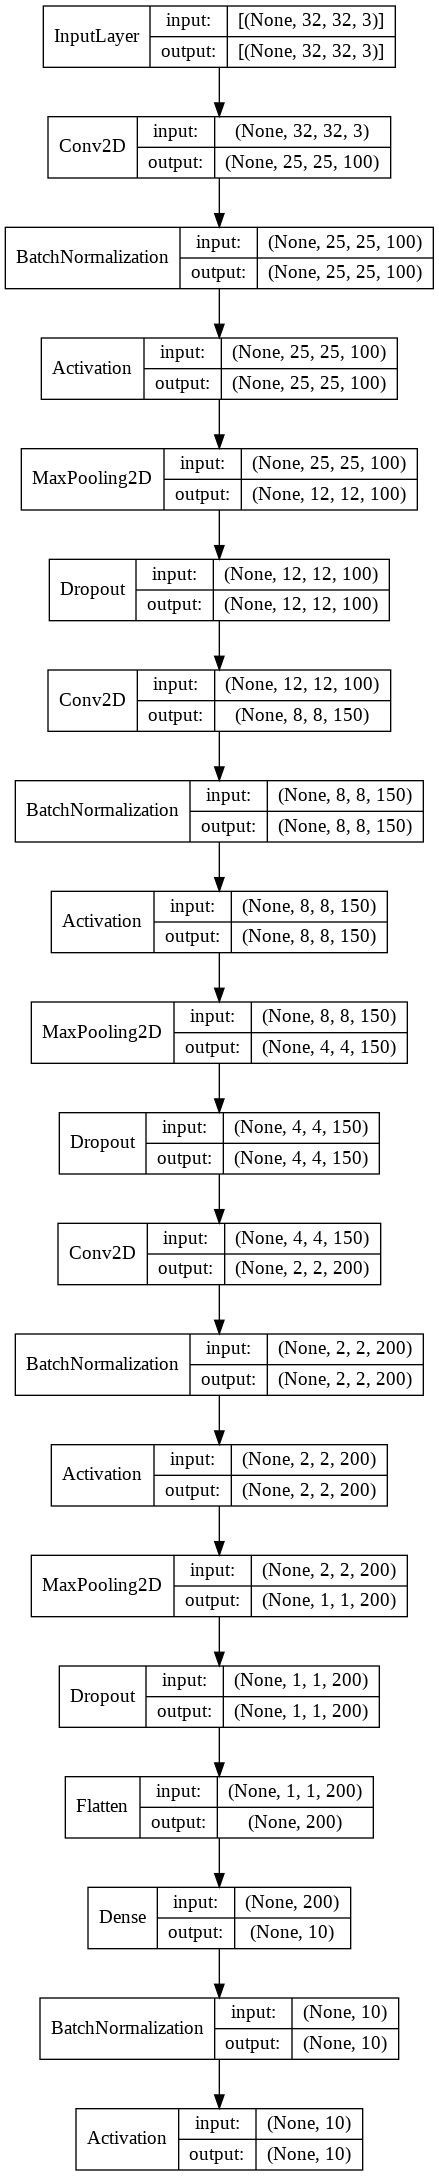

In [25]:
from tensorflow.keras.utils import plot_model

x_in = Input(shape=X_train.shape[1:])


# Block 1
x = Conv2D(filters=100, kernel_size=8 ,activation=None, input_shape=x_in.shape[1:])(x_in)
x = BatchNormalization(epsilon=0.001, momentum=0.75)(x)
x = Activation(activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

# Block 2
print(x.shape)
x = Conv2D(filters=150, kernel_size=5 ,activation=None)(x)
x = BatchNormalization(epsilon=0.001, momentum=0.75)(x)
x = Activation(activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)

# Block 3
x = Conv2D(filters=200, kernel_size=3 ,activation=None)(x)
x = BatchNormalization(epsilon=0.001, momentum=0.75)(x)
x = Activation(activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.2)(x)


# Fully connected part
x = Flatten()(x)
x = Dense(10, activation=None)(x)
x = BatchNormalization(epsilon=0.001, momentum=0.75)(x)
x = Activation(activation='softmax')(x)


model = Model(inputs=x_in, outputs=x)

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
model.summary(100)
plot_model(model, show_shapes=True, show_layer_names=False)

In [26]:
history = model.fit(X_train, y_train_c, batch_size=32, epochs=25, verbose=1, validation_split=0.2)
#history = model.fit(X_train, y_train_c, batch_size=32, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/25
1250/1250 [==============================] - 312s 249ms/step - loss: 1.5494 - accuracy: 0.4394 - val_loss: 1.2754 - val_accuracy: 0.5588
Epoch 2/25
1250/1250 [==============================] - 323s 259ms/step - loss: 1.2649 - accuracy: 0.5491 - val_loss: 1.1786 - val_accuracy: 0.5781
Epoch 3/25
1250/1250 [==============================] - 324s 259ms/step - loss: 1.1403 - accuracy: 0.5933 - val_loss: 1.0679 - val_accuracy: 0.6234
Epoch 4/25
1250/1250 [==============================] - 323s 258ms/step - loss: 1.0640 - accuracy: 0.6241 - val_loss: 0.9741 - val_accuracy: 0.6564
Epoch 5/25
1250/1250 [==============================] - 322s 258ms/step - loss: 0.9931 - accuracy: 0.6524 - val_loss: 0.9169 - val_accuracy: 0.6779
Epoch 6/25
1250/1250 [==============================] - 315s 252ms/step - loss: 0.9484 - accuracy: 0.6652 - val_loss: 0.8649 - val_accuracy: 0.7010
Epoch 7/25
1250/1250 [==============================] - 313s 250ms/step - loss: 0.9010 - accuracy: 0.6831 - val_

In [27]:
score = model.evaluate(X_test, y_test_c, batch_size=128, verbose=0)

for i in range(len(score)):
    print("Test " + model.metrics_names[i] + " = %.3f" % score[i])

Test loss = 0.701
Test accuracy = 0.759


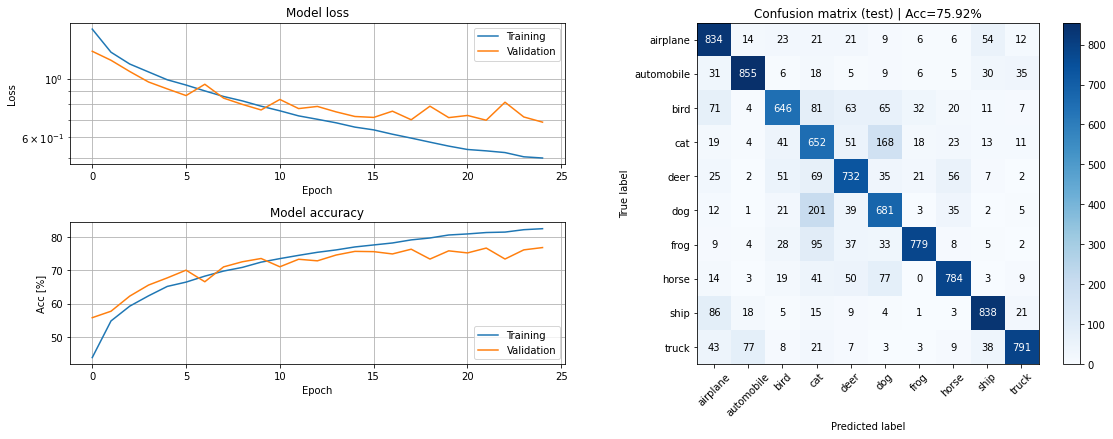

In [28]:
PlotModelEval(model, history, X_test, y_test, cifar_labels)

In [29]:
# if I want to save my model:
model.save("image-classifier.h5")

## **Ideas for further improvement**

Some things and links to look into, that might improve the performance:
* Further tweak or change the optimizer or training parameters.
* Tweak the filter parameters, such as numbers and sizes of filters.
* Use other activation functions.
* Add L1/L2 regularization (see https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
* Look into other possible layers (see https://www.tensorflow.org/api_docs/python/tf/keras/layers), e.g. the global pooling layers.
* Take inspiration from some well-known architectures, such as ResNet or VGG16. 
* Use model ensembing? (training multiple models that vote on or average the outputs - this will take a lot of time to train though...)
* Use data augmentation to create a larger training set (see https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).
